# BERT  Machine Reading Comprehension using DRCD

本範例展示如何透過 huggingface pytorch 訓練出 transformer based 中文機器閱讀理解模型。

閱讀理解又稱為問答系統，給定一個文章段落和問題，機器需從段落中找尋問題對應的答案，

本質上是尋找問題的答案位在段落的哪個索引區間(start_index, end_index)，如下圖所示，

若文章段落(paragraph)包含512個token，則模型將從這512個token中，

尋找哪一個token最適合作為答案的開始位置(start_index)，哪一個token最適合作為答案的結束位置(end_index)

本範例將透過[台達閱讀理解資料集](https://arxiv.org/abs/1806.00920)展示如何訓練一個中文的機器閱讀理解模型。


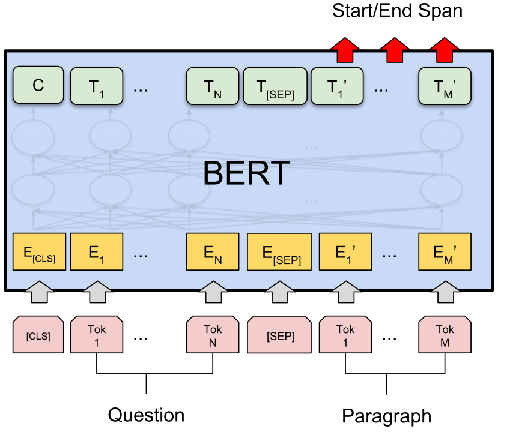

# Delta Reading Comprehension Dataset

台達閱讀理解資料集 Delta Reading Comprehension Dataset (DRCD) 屬於通用領域繁體中文機器閱讀理解資料集。 本資料集期望成為適用於遷移學習之標準中文閱讀理解資料集。 本資料集從2,108篇維基條目中整理出10,014篇段落，並從段落中標註出30,000多個問題

## Data format 資料格式

### version : 資料集版本
#### data :

    -title : : 文章標題 
    -id : : 文章編號
    -paragraphs :
        -id : : 文章編號_段落編號     
        -context : : 段落內容
        -qas :
            -question : : 問題內容
            -id : : 文章編號_段落編號_問題編號
            -answers :
                -answer_start : text在文中位置
                -id : : "1"表示為人工標註的答案，"2"以上為人工答題的答案
                -text : : 答案內容
                
## Example
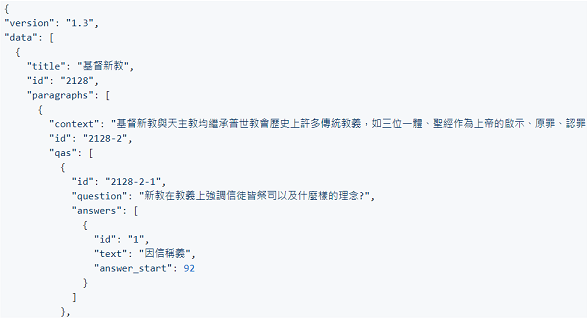

## Reference
Shao, Chih Chieh, et al. "Drcd: a chinese machine reading comprehension dataset." arXiv preprint
arXiv:1806.00920 (2018).


In [ ]:
!pip install -r requirements.txt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import *
import numpy as np
import pandas as pd
import json
from time import strftime, gmtime
from opencc import OpenCC
import pyprind
import argparse
import datetime

In [9]:
class DRCDRawData():
    def __init__(self, train_path=None, test_path=None, dev_path=None):
        if train_path != None:
            self.train = self.load_data(train_path)
        if test_path != None:
            self.test = self.load_data(test_path)
        if dev_path != None:
            self.dev = self.load_data(dev_path)
    def load_data(self, path):
        dataset = json.load(open(path, encoding='utf-8'))
        result = []
        for i in range(len(dataset['data'])):
            for j in dataset['data'][i]['paragraphs']:
                context = j['context']
                for qa in j['qas']:
                    question = qa['question']
                    if qa['answers']:
                        result.append([context, question, qa['answers'][0]['text']])                     
        return result

Mon Nov 09 14:10:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.50       Driver Version: 442.50       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P2000       WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   41C    P8    N/A /  N/A |    331MiB /  4096MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Dataset

In [10]:
class DRCD(Dataset):
    def __init__(self, data, model_type, device, language):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained(model_type)
        self.device = device
        self.cc = OpenCC('t2s') # tw->china
        self.language = language
    
    def __getitem__(self, idx):
        
        paragraph, question, ans = self.data[idx][0], self.data[idx][1], self.data[idx][2] 
        
        if self.language == 'china':
            paragraph, question, ans = self.cc.convert(paragraph), self.cc.convert(question), self.cc.convert(ans)
        
        # Tokenize and prepare for the model a sequence or a pair of sequences. 
        # so unlike 'encode' just encode to ids, encode_plus return not only ids 
        # but token_type_ids, attention_mask also
        token_tensor = self.tokenizer.encode_plus(question, paragraph, max_length=512, 
                                                  truncation=True, pad_to_max_length=True)
        
        ans_encode = self.tokenizer.encode(ans)
        s_tensor, e_tensor = self.find_ans_index(token_tensor, ans_encode)

        return {'input_ids': torch.tensor(token_tensor['input_ids']).to(self.device),
                'token_type_ids': torch.tensor(token_tensor['token_type_ids']).to(self.device),
                'attention_mask': torch.tensor(token_tensor['attention_mask']).to(self.device),
                's_tensor': s_tensor.to(self.device),
                'e_tensor': e_tensor.to(self.device)}
    
    def __len__(self):
        return len(self.data)
    
    def find_ans_index(self, token_tensor, ans_encode):
        s_idx, e_idx = [0] * 512, [0] * 512

        # answer's token (removing [CLS] and [SEP] by [1:-1])
        s_tok = ans_encode[1:-1]
        
        # find the idx of paragraph startwith ans's first token 
        s_list = [i for i, x in enumerate(token_tensor['input_ids']) if x == s_tok[0]]
      
        for s_pos in s_list:
            e_pos = s_pos + len(s_tok)
            if e_pos > 511:
                continue
            if token_tensor['input_ids'][s_pos:e_pos] == s_tok:
                s_idx[s_pos] = 1
                e_idx[e_pos-1] = 1
                break
        return  torch.Tensor(s_idx), torch.Tensor(e_idx)
    

# Model

In [11]:
class BertForReadingComprehension(nn.Module):
    def __init__(self, model_type):
        super(BertForReadingComprehension, self).__init__()

        config = BertConfig.from_pretrained(model_type, output_hidden_states=True)
        self.bert_model = BertModel.from_pretrained(model_type, config=config)
        
        self.s_decoder = nn.Sequential(nn.Linear(config.hidden_size, 1)) 
        self.e_decoder = nn.Sequential(nn.Linear(config.hidden_size, 1))

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None): 
        hidden = self.bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
        
        s = self.s_decoder(hidden).squeeze()
        e = self.e_decoder(hidden).squeeze()
        
        # mask question part, because ans only appears in the paragraph.
        mask = token_type_ids.clone().float().to(hidden.device).detach()
        mask[mask != 1] = float('-inf')

        return s + mask, e + mask


# Test

In [12]:
def test(model, data, args, tp):
    if tp == 'test':
        dataset = DRCD(data.test, args.model_type, args.device, args.language)
        print(f'Testing...{len(dataset)}')
    elif tp == 'dev':   
        dataset = DRCD(data.dev, args.model_type, args.device, args.language)
        print(f'Dev...{len(dataset)}')
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    model.eval()
    loss,i = 0,0
    criterion = nn.BCELoss()
    with torch.no_grad():
        for batch in loader:
            i = i+1
            inp_ids, tok_id, att_m, slabel, elabel = batch['input_ids'], batch['token_type_ids'], batch['attention_mask'], batch['s_tensor'], batch['e_tensor']
            s, e = model(input_ids=inp_ids, attention_mask=att_m, token_type_ids=tok_id)
            #print(f's {s} \n e {e} \n sl {torch.softmax(s,dim=-1)} \n el {torch.softmax(e,dim=-1)} \n ')
            #print(f'SL {slabel} \n EL {elabel}')
            batch_loss = (criterion(torch.softmax(s,dim=-1),slabel) + criterion(torch.softmax(e,dim=-1),elabel)) / 2
            loss += batch_loss     
        print(f'Result: LOSS: {loss} AVG: {loss/i} ')
    return loss

In [13]:
def train(data, args):
    dataset = DRCD(data.train, args.model_type, args.device, args.language)
    trainLoader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    model = BertForReadingComprehension(args.model_type).to(args.device)
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = AdamW(parameters, lr=args.learning_rate, weight_decay=args.weight_decay)
    criterion = nn.BCELoss()
    model.train()
    min_loss = 100000
    for ei in range(args.epoch):
        model.train()
        epoch_loss,i,check_loss = 0,0,0
        for batch in trainLoader:
            i+=1
            inp_ids, tok_id, att_m, slabel, elabel = batch['input_ids'], batch['token_type_ids'], batch['attention_mask'], batch['s_tensor'], batch['e_tensor']
            
            s, e = model(input_ids=inp_ids, 
                         attention_mask=att_m,
                         token_type_ids=tok_id)
            
            #print(f's {s} \n e {e} \n sl {torch.softmax(s,dim=-1)} \n el {torch.softmax(e,dim=-1)} \n ')
            #print(f'SL {slabel} \n EL {elabel}')
            
            batch_loss = (criterion(torch.softmax(s,dim=-1),slabel) + criterion(torch.softmax(e,dim=-1),elabel)) / 2
            epoch_loss += batch_loss
            check_loss += batch_loss
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if i % 1000==0:
                print(f'1000 batch LOSS {check_loss}')
                check_loss = 0
        dev_loss = test(model, data, args, 'dev') 
        if dev_loss < min_loss:
            model_name = 'BertForReadingComprehension'+'_'+(datetime.now()).strftime("%m%d")+'_'+'.pt' 
            print('dev_loss:', dev_loss, ', min_loss:', min_loss)
            print('save current best model:', model_name)
            
            min_loss = dev_loss
            torch.save(model.state_dict(), f'model/{model_name}')         
            
        print(f'===Epoches: {ei} Loss {epoch_loss}===')  
    print('---Training Finished---')        
    return best_model

# Main

In [14]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
parser = argparse.ArgumentParser([])
parser.add_argument('--batch-size', default=8, type=int)
parser.add_argument('--epoch', default=10, type=int)
parser.add_argument('--learning-rate', default=1e-5, type=float)    
parser.add_argument('--weight-decay', default=0.001, type=float)
parser.add_argument('--model-type', default='hfl/chinese-roberta-wwm-ext', type=str)  #model_type = 'hfl/chinese-bert-wwm'  'hfl/chinese-roberta-wwm-ext'  'hfl/chinese-roberta-wwm-ext-large'
parser.add_argument('--device', default=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'), type=int)
parser.add_argument('--language', default='tw', type=str)
args = parser.parse_args([])
args

True
Quadro P2000


Namespace(batch_size=8, device=device(type='cuda', index=0), epoch=10, language='tw', learning_rate=1e-05, model_type='hfl/chinese-roberta-wwm-ext', weight_decay=0.001)

In [15]:
data = DRCDRawData(train_path='./dataset/DRCD_train.json', test_path='./dataset/DRCD_test.json', dev_path='./dataset/DRCD_dev.json')
data.train[0]

['2010年引進的廣州快速公交運輸系統，屬世界第二大快速公交系統，日常載客量可達100萬人次，高峰時期每小時單向客流高達26900人次，僅次於波哥大的快速交通系統，平均每10秒鐘就有一輛巴士，每輛巴士單向行駛350小時。包括橋樑在內的站台是世界最長的州快速公交運輸系統站台，長達260米。目前廣州市區的計程車和公共汽車主要使用液化石油氣作燃料，部分公共汽車更使用油電、氣電混合動力技術。2012年底開始投放液化天然氣燃料的公共汽車，2014年6月開始投放液化天然氣插電式混合動力公共汽車，以取代液化石油氣公共汽車。2007年1月16日，廣州市政府全面禁止在市區內駕駛摩托車。違反禁令的機動車將會予以沒收。廣州市交通局聲稱禁令的施行，使得交通擁擠問題和車禍大幅減少。廣州白雲國際機場位於白雲區與花都區交界，2004年8月5日正式投入運營，屬中國交通情況第二繁忙的機場。該機場取代了原先位於市中心的無法滿足日益增長航空需求的舊機場。目前機場有三條飛機跑道，成為國內第三個擁有三跑道的民航機場。比鄰近的香港國際機場第三跑道預計的2023年落成早8年。',
 '廣州的快速公交運輸系統每多久就會有一輛巴士？',
 '10秒鐘']

In [52]:
mode = 'train'

if mode == 'train': 
    best_model = train(data, args)
elif mode == 'test' or mode == 'dev':
    model_name = 'bertDRCD_0808_1213.pt'
    test_model = BertForReadingComprehension(args.model_type).to(args.device)
    test_model.load_state_dict(torch.load(f'model/{model_name}'))
    test(test_model, data, args, mode)

#22.53021812438965
#22.579822540283203
# Result: LOSS: 3.2912609577178955 AVG: 0.003765744622796774 
# Result: LOSS: 3.526034116744995 AVG: 0.004002308938652277 

C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 4.00 GiB total capacity; 2.80 GiB already allocated; 44.80 MiB free; 208.68 MiB cached)

# Package

In [16]:
class InferenceModel():
    def __init__(self, model_path, model_type, language): 

        self.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

        config = BertConfig.from_pretrained(model_type,output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained(model_type)
        self.model = BertForReadingComprehension(model_type).to(self.device)
        self.model.load_state_dict(torch.load(model_path)) 
        self.language = language
        self.c2tw = OpenCC('s2t') # china to tw
        self.tw2c = OpenCC('t2s') # tw to china

    def inference(self, content, question): 
        content, question = self.clean_str(content, question)
        with torch.no_grad():
            
            token_tensor = self.tokenizer.encode_plus(str(question), str(content), max_length=512, 
                                                      truncation=True, pad_to_max_length=True)
            token = torch.tensor(token_tensor['input_ids']).unsqueeze(0).to(self.device)
            segment = torch.tensor( token_tensor['token_type_ids']).unsqueeze(0).to(self.device)
            mask = torch.tensor( token_tensor['attention_mask'] ).unsqueeze(0).to(self.device)
            answer_start, answer_end = self.model(input_ids=token,attention_mask=mask,token_type_ids=segment) 
      
            tokens = self.tokenizer.convert_ids_to_tokens(token.squeeze())
            answer_start = answer_start.argmax(1)
            answer_end = answer_end.argmax(1)
            #print(answer_start,answer_end)
            if answer_start > answer_end :
                return 'Invalid span.'
            
            #print(answer_start,answer_end)
            answer = ''.join(tokens[answer_start:answer_end+1])
            if self.language == 'tw':
                answer = self.c2tw.convert(answer) 
        return answer
    
    def clean_str(self, content, question):
        content = content.replace(' ','')
        question = question.replace(' ','')
        if self.language == 'china':
            content = self.tw2c.convert(content)
            question = self.tw2c.convert(question)
        return content, question

In [17]:
print(torch.__version__)
model_name = 'bertDRCD_1023_1619.pkl'
drcd_model = InferenceModel(f'model/{model_name}','hfl/chinese-roberta-wwm-ext','tw')

1.3.1


In [ ]:
from flask import Flask,request,jsonify
from flask_cors import CORS
app = Flask(__name__)
CORS(app)
@app.route("/predict",methods=['POST'])
def predict():
    paragraph = request.json["paragraph"]
    question = request.json["question"]
    print('paragraph:', paragraph)
    print('question:', question)
    print('--------------------------')
    try:
        result = {'paragraph': paragraph, 'qa': {}}
        for q in question:
            if q:
                result['qa'][q] = drcd_model.inference(paragraph, q)
        return jsonify(result)
    except Exception as e:
        print(e)
        return jsonify({"result": "Model Failed"})

if __name__ == "__main__":
    app.run('0.0.0.0',port=8000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:8000/ (Press CTRL+C to quit)
10.137.47.174 - - [09/Nov/2020 14:26:16] "POST /predict HTTP/1.1" 400 -


paragraph: 拜訪今通技術總監何昌明，主要油電混合立式注塑機方案交流與推廣。目前何經理希望我們可以整個射臺或者電動部分+絲杠+loadcell一起提供，KEBA是整個射臺一起供，鴻訊與盟立是電控+絲杠+loadcell+同步帶輪。目前何經理給了技術規格，計劃參加8月份橡塑展，但是目前橡塑展已經延期到2021年。'
question: ['拜訪誰?', '提出甚麼方案?', '何經理希望我們提供?', '橡塑展何時辦?', '何昌明是哪裡的總監?', '誰提供我們技術規格']
--------------------------


10.137.33.108 - - [09/Nov/2020 14:26:31] "POST /predict HTTP/1.1" 200 -
10.137.47.174 - - [09/Nov/2020 14:27:14] "POST /predict HTTP/1.1" 400 -
[2020-11-09 14:27:28,752] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\flask_cors\extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\pocheng.lin\AppData\Local\

paragraph: 拜訪今通技術總監何昌明，主要油電混合立式注塑機方案交流與推廣。目前何經理希望我們可以整個射臺或者電動部分+絲杠+loadcell一起提供，KEBA是整個射臺一起供，鴻訊與盟立是電控+絲杠+loadcell+同步帶輪。目前何經理給了技術規格，計劃參加8月份橡塑展，但是目前橡塑展已經延期到2021年。'
question: ['拜訪誰?', '提出甚麼方案?', '何經理希望我們提供?', '橡塑展何時辦?', '何昌明是哪裡的總監?', '誰提供我們技術規格']
--------------------------


10.137.33.108 - - [09/Nov/2020 14:28:28] "POST /predict HTTP/1.1" 200 -
10.137.47.174 - - [09/Nov/2020 14:29:25] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:29:53] "POST /predict HTTP/1.1" 400 -


paragraph: 拜訪今通技術總監何昌明，主要油電混合立式注塑機方案交流與推廣。目前何經理希望我們可以整個射臺或者電動部分+絲杠+loadcell一起提供，KEBA是整個射臺一起供，鴻訊與盟立是電控+絲杠+loadcell+同步帶輪。目前何經理給了技術規格，計劃參加8月份橡塑展，但是目前橡塑展已經延期到2021年。'
question: ['拜訪誰?', '提出甚麼方案?', '何經理希望我們提供?', '橡塑展何時辦?', '何昌明是哪裡的總監?', '誰提供我們技術規格']
--------------------------


10.137.33.108 - - [09/Nov/2020 14:30:34] "POST /predict HTTP/1.1" 200 -
10.137.47.174 - - [09/Nov/2020 14:33:19] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:33:24] "POST /predict/ HTTP/1.1" 404 -
10.137.47.174 - - [09/Nov/2020 14:33:45] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:33:48] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:33:49] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:33:51] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:33:58] "GET /predict HTTP/1.1" 405 -
10.137.47.174 - - [09/Nov/2020 14:34:02] "GET / HTTP/1.1" 404 -
10.137.47.174 - - [09/Nov/2020 14:34:13] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:35:32] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:35:33] "POST /predict HTTP/1.1" 400 -


paragraph: 我同學是小明，今年12歲
question: ['小明幾歲?']
--------------------------


10.137.33.253 - - [09/Nov/2020 14:35:54] "POST /predict HTTP/1.1" 200 -
10.137.47.174 - - [09/Nov/2020 14:36:29] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:36:30] "POST /predict HTTP/1.1" 400 -
10.137.47.174 - - [09/Nov/2020 14:37:09] "POST /predict HTTP/1.1" 400 -
[2020-11-09 14:37:26,064] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\flask_cors\extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\s

paragraph: 拜訪今通技術總監何昌明，主要油電混合立式注塑機方案交流與推廣。目前何經理希望我們可以整個射臺或者電動部分+絲杠+loadcell一起提供，KEBA是整個射臺一起供，鴻訊與盟立是電控+絲杠+loadcell+同步帶輪。目前何經理給了技術規格，計劃參加8月份橡塑展，但是目前橡塑展已經延期到2021年。'
question: ['拜訪誰?', '提出甚麼方案?', '何經理希望我們提供?', '橡塑展何時辦?', '何昌明是哪裡的總監?', '誰提供我們技術規格']
--------------------------


10.137.32.195 - - [09/Nov/2020 14:41:52] "POST /predict HTTP/1.1" 200 -


paragraph: 拜訪今通技術總監何昌明，主要油電混合立式注塑機方案交流與推廣。目前何經理希望我們可以整個射臺或者電動部分+絲杠+loadcell一起提供，KEBA是整個射臺一起供，鴻訊與盟立是電控+絲杠+loadcell+同步帶輪。目前何經理給了技術規格，計劃參加8月份橡塑展，但是目前橡塑展已經延期到2021年。'
question: ['拜訪誰?', '提出甚麼方案?', '何經理希望我們提供?', '橡塑展何時辦?', '何昌明是哪裡的總監?', '誰提供我們技術規格']
--------------------------


10.137.47.174 - - [09/Nov/2020 14:42:04] "POST /predict HTTP/1.1" 200 -
10.137.47.174 - - [09/Nov/2020 14:48:06] "GET /predict%0A HTTP/1.1" 405 -
10.137.47.174 - - [09/Nov/2020 14:48:17] "GET /predict HTTP/1.1" 405 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['多人少住院隔離中']
--------------------------


10.137.47.174 - - [09/Nov/2020 14:48:22] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['多人少住院隔離中', '目前有多少累積案例']
--------------------------


10.137.47.174 - - [09/Nov/2020 14:48:50] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['多人少住院隔離中', '目前有多少累積相關通報']
--------------------------


10.137.47.174 - - [09/Nov/2020 14:49:05] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['案579何時來台工作', '多人少住院隔離中', '目前有多少累積相關通報']
--------------------------


10.137.47.174 - - [09/Nov/2020 14:49:42] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['案579何時來台工作', '多人少住院隔離中', '目前有多少累積相關通報']
--------------------------


10.137.33.108 - - [09/Nov/2020 14:50:47] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['案579何時來台工作', '多人少住院隔離中', '目前有多少累積相關通報', '入境症狀']
--------------------------


10.137.47.174 - - [09/Nov/2020 14:51:35] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['案579何時來台工作', '多人少住院隔離中', '目前有多少累積相關通報', '入境症狀', '是否居家檢疫']
--------------------------


10.137.47.174 - - [09/Nov/2020 14:52:23] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['案579何時來台工作', '多人少住院隔離中', '目前有多少累積相關通報', '入境症狀', '是否居家檢疫', '衛生單位已掌握多少個案']
--------------------------


10.137.47.174 - - [09/Nov/2020 14:52:56] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['案579何時來台工作', '多人少住院隔離中', '目前有多少累積相關通報', '入境症狀', '是否居家檢疫', '衛生單位已掌握多少個案']
--------------------------


10.137.33.108 - - [09/Nov/2020 14:53:59] "POST /predict HTTP/1.1" 200 -


paragraph: 中央流行疫情指揮中心今公布國內新增1例境外移入COVID-19病例(案579)，為20多歲烏克蘭籍女子，11月3日自烏克蘭經土耳其入境臺灣。中央流行疫情指揮中心醫療應變組副組長羅一鈞表示，案579於11月3日來台工作，搭機前3日內檢驗陰性，入境時無上呼吸道症狀，入境後至防疫旅館進行居家檢疫，11月6日居家檢疫期間主動通報有鼻塞、嗅味覺異常情形，由衛生單位採檢送驗，於今日確診，目前住院隔離中。羅一鈞表示，衛生單位已掌握個案接觸者共54人，同行者8人皆持搭機前3日內檢驗陰性報告，目前無不適症狀，列為居家隔離；同班機前後2排座位旅客共10人（扣除3名同行者）列為居家隔離。羅一鈞表示，案579在台公司接觸者及旅館工作人員共7人，因僅配戴口罩，列為居家隔離（居家隔離人數共25人）。醫護人員17名均著適當防護裝備，列自主健康管理，班機機組人員皆為外籍人士，共12人，均已離境。指揮中心統計，截至目前國內累計104,017例新型冠狀病毒肺炎相關通報(含102,449例排除)，其中578例確診，分別為486例境外移入，55例本⼟病例，36例敦睦艦隊及1例不明； 另1例(案530)移除為空號。確診個案中7人死亡、526人解除隔離、45人住院隔離中。
question: ['案579何時來台工作', '多人少住院隔離中', '目前有多少累積相關通報', '入境症狀', '是否居家檢疫', '衛生單位已掌握多少個案', '班機共有幾位旅客']
--------------------------


10.137.33.108 - - [09/Nov/2020 14:57:09] "POST /predict HTTP/1.1" 200 -


paragraph: 1艘停泊高雄鼓山區新濱碼頭的台華輪，今天下午3點23分突然冒煙，高雄港務消防局、高市消防局出動人車搶救，3點43分迅速控制火勢，但3樓船艙冒出淡淡黑煙，4點15分熄滅。據了解船上1艘小艇遭波及，無人員受傷受困。消防人員向在場的船主了解原因，初步釐清，可能是焊接不慎引發火警。據指，這艘台華輪今天剛才從澎湖駛回台灣，在新濱碼頭靠港，並進行船上整修工程，但下午3樓船艙突傳冒煙，疑似起火點有堆雜物，幸好起火時船上已沒有遊客，僅26名員工，也迅速疏散完畢。
question: ['有沒有人員受傷']
--------------------------


10.137.47.174 - - [09/Nov/2020 16:29:04] "POST /predict HTTP/1.1" 200 -


paragraph: 國立台灣大學校內今午發生墜樓意外，一名年約20歲女子被人發現倒臥校內綜合大樓旁，意識不清，救護人員獲報後已將其送往台大醫院救治。台北市消防局表示，今天中午12時39分接獲民眾報案，派員到場時發現該名女子意識不清、倒臥在地，疑似墜樓，墜落高度及原因不明。警方目前已介入調查，確切事發經過有待進一步釐清。
question: ['發生甚麼意外', '原因是甚麼']
--------------------------


10.137.47.174 - - [09/Nov/2020 16:31:46] "POST /predict HTTP/1.1" 200 -


paragraph: 國立台灣大學校內今午發生墜樓意外，一名年約20歲女子被人發現倒臥校內綜合大樓旁，意識不清，救護人員獲報後已將其送往台大醫院救治。台北市消防局表示，今天中午12時39分接獲民眾報案，派員到場時發現該名女子意識不清、倒臥在地，疑似墜樓，墜落高度及原因不明。警方目前已介入調查，確切事發經過有待進一步釐清。
question: ['發生甚麼意外', '原因是甚麼', '何時報案']
--------------------------


10.137.47.174 - - [09/Nov/2020 16:32:14] "POST /predict HTTP/1.1" 200 -


paragraph: 國立台灣大學校內今午發生墜樓意外，一名年約20歲女子被人發現倒臥校內綜合大樓旁，意識不清，救護人員獲報後已將其送往台大醫院救治。台北市消防局表示，今天中午12時39分接獲民眾報案，派員到場時發現該名女子意識不清、倒臥在地，疑似墜樓，墜落高度及原因不明。警方目前已介入調查，確切事發經過有待進一步釐清。
question: ['發生甚麼意外', '原因是甚麼', '何時報案', '誰報案的']
--------------------------


10.137.47.174 - - [09/Nov/2020 16:32:29] "POST /predict HTTP/1.1" 200 -


paragraph: 拜訪今通技術總監何昌明，主要油電混合立式注塑機方案交流與推廣。目前何經理希望我們可以整個射臺或者電動部分+絲杠+loadcell一起提供，KEBA是整個射臺一起供，鴻訊與盟立是電控+絲杠+loadcell+同步帶輪。目前何經理給了技術規格，計劃參加8月份橡塑展，但是目前橡塑展已經延期到2021年。'
question: ['拜訪誰?', '提出甚麼方案?', '何經理希望我們提供?', '橡塑展何時辦?', '何昌明是哪裡的總監?', '誰提供我們技術規格']
--------------------------


10.137.47.174 - - [09/Nov/2020 16:33:29] "POST /predict HTTP/1.1" 200 -


In [18]:
# paragraph = \
# '蒂埃里·亨利是前法國足球運動員。在他職業生涯參加的國際賽事中，他為法國隊出場123次，\
# 打進51球。他的首個國際比賽進球是在1998年世界盃對陣南非的比賽中。截至2015年10月，他是法國隊的頭號射手\
# 。2007年10月，他在對陣立陶宛的比賽中打進兩球，打破了米歇爾·普拉蒂尼42球的法國隊進球紀錄。亨利於2010年7月正式退役\
# 。亨利在2009年10月對奧地利的比賽中打進了個人國家隊第51粒進球，這也是他的最後一粒進球\
# 。亨利從未在國際比賽中上演過帽子戲法，儘管他曾7次在單場比賽梅開二度。\
# 他在對陣馬爾他的比賽中進球最多，在2004年歐洲國家盃外圍賽中曾單場上演大四喜。\
# 亨利一半以上的進球來自於主場比賽，他的51個進球中有31個是在法國本土打進，\
# 其中有20個在法蘭西體育場。亨利在熱身賽中共打進16球。在2003年國際足總洲際國家盃上\
# ，亨利打進四球並榮膺最佳射手，他也因此被評為「賽事最傑出球員」。\
# 亨利在歐洲國家盃外圍賽中打入12球，其中在2004年歐洲杯外圍賽打進6球，他最終排在射手榜第三位。'

# question = ['蒂埃里·亨利是誰','蒂埃里·亨利為法國隊出場幾次','亨利曾在國際比賽中上演過帽子戲法嗎?',
#             '蒂埃里·亨利是誰在哪年歐洲國家盃外圍賽中曾單場上演大四喜?','亨利在熱身賽中共打進多少球?']

# for q in question:
#     print(q + ':  '+ drcd_model.inference(paragraph,q))

C:\Users\pocheng.lin\AppData\Local\Continuum\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


蒂埃里·亨利是誰:  前法國足球運動員
蒂埃里·亨利為法國隊出場幾次:  123次
亨利曾在國際比賽中上演過帽子戲法嗎?:  從未
蒂埃里·亨利是誰在哪年歐洲國家盃外圍賽中曾單場上演大四喜?:  2004年
亨利在熱身賽中共打進多少球?:  16球
